In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Load raw data

In [2]:
# Harmonized MHAS data
mhas = pd.read_csv(
    'data/MHAS.csv', # Modify path to harmonized MHAS data
    low_memory=False
)

# Raw MexCog 2016 data
cog_16 = pd.read_csv(
    'data/Mex-cog2016_raw.csv', # Modify path to raw MexCog 2016 data
    low_memory=False
)

# Harmonized MexCog 2016 data
cog_16_p = pd.read_csv(
    'data/Mex-cog2016.csv', # Modify path to harmonized MexCog 2016 data
    low_memory=False
)

# Raw MexCog 2021 data
cog_21 = pd.read_csv(
    'data/Mex-cog2021.csv', # Modify path to raw MexCog 2021 data
    low_memory=False
)

# Process MexCog data
Extract the provided MMSE score, number of attempts during MMSE-related questions, and calculate the CSI'D score based on the questions from the raw data.

In [3]:
def export_target_variables(
        data: pd.DataFrame,
        complete_questions: list,
        part_questions: list,
        csid_name: str,
        mmse_c_name: str,
        mmse_a_name: str
    ) -> pd.DataFrame:
    """
    Export MMSE and CSID for MexCog data subsets.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing a raw MexCog wave data.
    - complete_questions (list): A list with the names of the questions used to create the CSI'D
    score which only have one part, hence the name complete questions.
    - part_questions (list): A list with the names of the questions used to create the CSI'D
    score which have two parts that must be combined.
    - csid_name (str): The name for the resulting CSI'D score in the returned dataset.
    - mmse_c_name (str): The column name for the correct MMSE variable in the raw data.
    - mmse_a_name (str): The column name for the number of attempts used during the MMSE-related
    questions in the raw data

    Returns:
    - pd.DataFrame: A DataFrame with the MexCog subjects' unique id, CSI'D, and MMSE score (correct
    score and number of attempts)
    """

    data_subset = data[
        ['unhhidnp', mmse_c_name, mmse_a_name] 
        + complete_questions 
        + part_questions
    ]
    data_subset.loc[:, [csid_name]] = -1
    data_subset.loc[:, ['Point-Score']] = -1
    options = [
        '9: Refused / No responde',
        '8: Does not know / No sabe',
        '.i: Incomplete interview / Incompleto',
        '.m: Missing / Sin valor',
        '8: Refused'
    ]
    # Combine the part questions into a unique score if both answers include the option 1.
    for idx, participant in data_subset.iterrows():
        point_1 = participant[part_questions[0]]
        point_2 = participant[part_questions[1]] 
        if point_1 in options or point_2 in options:
            continue
        elif '2:' in point_1 or '2:' in point_2:
            data_subset.loc[idx, 'Point-Score'] = 0
        elif '1:' in point_1 and '1:' in point_2:
            data_subset.loc[idx, 'Point-Score'] = 1 
    
    # Add up the score based on the complete and part questions' answers.
    for idx, participant in data_subset.iterrows():
        item_1 = participant[complete_questions[0]]
        item_2 = participant[complete_questions[1]]
        item_3 = participant[complete_questions[2]]
        item_4 = participant['Point-Score']
        csid_score = 0
        
        if '3:' in item_1 or '3:' in item_2 or '3:' in item_3:
            data_subset.loc[idx,csid_name] = -2
            continue
        elif (('1:' not in item_1 and '2:' not in item_1) or
              ('1:' not in item_2 and '2:' not in item_2) or
              ('1:' not in item_3 and '2:' not in item_3) or
              item_4 == -1):
            # When any of the answers is missing the CSI'D score isn't provided as per instructions
            # from the harmonized codebook
            data_subset.loc[idx, csid_name] = -1
            continue
        else:
            if '1:' in item_1:
                csid_score += 1
            if '1:' in item_2:
                csid_score += 1
            if '1:' in item_3:
                csid_score += 1
            if item_4 != -1:
                csid_score += item_4
        data_subset.loc[idx, csid_name] = csid_score

    data_subset = data_subset.sort_values(by='unhhidnp')
    return data_subset[['unhhidnp', csid_name, mmse_c_name, mmse_a_name]]

def create_unhhidnp(df: pd.DataFrame) -> None:
    """
    Create the unique ID for subjects in MexCog to establish the relationship with MHAS data.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the full dataset with the original columns.
    """
    df.loc[:,['unhhidnp']] = (df['cunicah'].astype(str) + df['np'].astype(str))
    df.loc[:,['unhhidnp']] = df['unhhidnp'].astype(int)

In [4]:
# Create the unique IDs and then use the dataset to export the target variables
create_unhhidnp(cog_16)
cog_16_subset = export_target_variables(
    cog_16,
    ['mc_q25_16','mc_q27_16','mc_q29_16'],
    ['mc_q30_1_16','mc_q30_2_16'],
    'CSID_16',
    'MMSE_correct',
    'MMSE_attempts'
)
cog_16_subset.rename(
    columns={'MMSE_correct':'MMSE_correct_16','MMSE_attempts':'MMSE_attempts_16'},
    inplace=True
)
# Suggested dataset to use
cog_16_subset.to_csv(
    'data/MexCog_2016_subset.csv', # Modify path to desired location
    index=False
)

create_unhhidnp(cog_21)
cog_21_subset = export_target_variables(
    cog_21,
    ['mc_p24_21','mc_p26_21','mc_p28_21'],
    ['mc_p29_1_21','mc_p29_2_21'],
    'CSID_21',
    'MMSE_correct_21',
    'MMSE_attempts_21'
)
# Suggested dataset to use
cog_21_subset.to_csv(
    'data/MexCog_2021_subset.csv', # Modify path to desired location
    index=False
)

# MHAS Subset

In [5]:
# Filter MHAS based on participants from MexCog ancillary studies
unique_ids = set(list(cog_16['unhhidnp'])+list(cog_21['unhhidnp']))
mhas_subset = mhas[mhas['unhhidnp'].isin(unique_ids)]
mhas_fixed_subset = mhas_subset.copy()

## Suggested MHAS changes
We suggest three main changes:
- Calculating the scores for drawing questions related to the cognitive section of MHAS
- Categorizing the body mass index (BMI) in the categories proposed for a subset of subjects which participated on anthropometric ancillary studies
- Extracting a subset of the variables which we consider provide the most information without redundance.

### Picture drawing variables
How to harmonize the (r/s)Wddraw2 and (r/s)Wddraw1 variables.

In [6]:
#! We can only use (R/S)wDDRAW2 and (R/S)wDDRAW1
#! Variables to take into account : (R/S)wIDRAW2 w E [1,2], (R/S)wIDRAW1 w E [3,4,5]
#!                                  (R/S)wDDRAW2 w E [1,2], (R/S)wDDRAW1 w E [3,4,5]
#! RwDDRAW1 = 0, 1, or 2 is equal RwDDRAW2 = 0 ; RwDDRAW1 = 3 or 4 is equal RwDDRAW2 = 1; RwDDRAW1 = 5 or 6 is equal RwDDRAW2 = 2

new_columns = ['r3ddraw2', 's3ddraw2', 'r4ddraw2', 's4ddraw2', 'r5ddraw2', 's5ddraw2']
for variable_ in new_columns:
    mhas_subset.loc[:,[variable_]] = None

variables_needed = ['r3ddraw1', 's3ddraw1', 'r4ddraw1', 's4ddraw1', 'r5ddraw1', 's5ddraw1']
for idx, participant in mhas_subset.iterrows():
    for variable_ in variables_needed:
        variable_value = participant[variable_]
        if variable_value == '0' or variable_value == '1' or variable_value == '2':
            mhas_subset.loc[idx, variable_[0:-1]+'2'] = '0'
        elif variable_value == '3' or variable_value == '4':
            mhas_subset.loc[idx, variable_[0:-1]+'2'] = '1'
        elif variable_value == '5' or variable_value == '6':
            mhas_subset.loc[idx, variable_[0:-1]+'2'] = '2'
        else:
            continue

### BMI Categorization
Subjects self-reported their weight and height, which is the base to calculate the BMI (r/sWbmi). However, in the first three waves of MHAS some subjects participated in the anthropometric ancillary study where those physical indicators were measured and then another BMI was calculated (r/sWmbmi) and categorized (r/sWmbmicat). If both the self-reported and the measured BMI are present, the measured BMI was used.

In [7]:
def map_bmi(value: float):
    """
    Map the BMI to the following categories:
        1.Underweight (lt 18.5)
        2.Normal (18.5-24.9)
        3.Pre-obesity (25-29.9)
        4.Obesity class 1 (30-34.9)
        5.obesity class 2 (35-39.9)
        6.obesity class 3 (40+)
    
    Note: If the value is NaN then it is kept as is, otherwise it gets mapped.
    """
    if pd.isna(value):
        return value

    if value < 18.5:
        return '1.Underweight (lt 18.5)'
    elif value < 25:
        return '2.Normal (18.5-24.9)'
    elif value < 30:
        return '3.Pre-obesity (25-29.9)'
    elif value < 35:
        return '4.Obesity class 1 (30-34.9)'
    elif value < 40:
        return '5.obesity class 2 (35-39.9)'
    else:
        return '6.obesity class 3 (40+)'

In [8]:
# Loop through each wave to map the BMI
for i in range(1,6):
    # Repeat the process for main respondent and spouse variables
    for subject in ['r','s']:
        # Map missing values to NaN for easier processing to a new column named (r/s)Wbmi_m
        mhas_subset.loc[:,[f'{subject}{i}bmi_m']] = pd.to_numeric(mhas_subset[f'{subject}{i}bmi'], errors='coerce')
        if i < 4:
            # For waves 1-3 the measured bmi was taken into account
            # If both self-reported and measured BMI are provided, the measured value was preferred.
            mhas_subset.loc[:,[f'{subject}{i}mbmi_m']] = pd.to_numeric(mhas_subset[f'{subject}{i}mbmi'], errors='coerce')
            mhas_subset.loc[:,[f'{subject}{i}bmi_m']] = mhas_subset[f'{subject}{i}bmi_m'].mask(
                pd.notnull(mhas_subset[f'{subject}{i}mbmi_m']),
                mhas_subset[f'{subject}{i}mbmi_m']
            )
            mhas_subset.drop(columns=f'{subject}{i}mbmi_m')
        
        mhas_subset.loc[:,[f'{subject}{i}bmicat_m']] = mhas_subset[f'{subject}{i}bmi_m'].map(map_bmi)
        new_columns.extend([f'{subject}{i}bmi_m',f'{subject}{i}bmicat_m'])

### Extract variables
The "mhas_variables.txt" file contains the suggested variables to keep from MHAS.

In [9]:
# Load the file and filter the dataset, including the newly created columns
with open('mhas_variables.txt') as mhas_variables:
    variables = mhas_variables.readlines()
    variables = [x.replace('\n','') for x in variables]
    
    mhas_var_subset = mhas_subset[variables + new_columns]

In [10]:
# Suggested dataset to use
mhas_var_subset.to_csv(
    'data/MHAS_subset.csv', # Modify path to desired location
    index=False
)
mhas_var_subset.head()

,c2000cpindex,c2001cpindex,c2002cpindex,c2003cpindex,c2011cpindex,c2012cpindex,c2013cpindex,c2014cpindex,c2015cpindex,c2016cpindex,...,s3bmi_m,s3bmicat_m,r4bmi_m,r4bmicat_m,s4bmi_m,s4bmicat_m,r5bmi_m,r5bmicat_m,s5bmi_m,s5bmicat_m
1,63.299999,67.300003,70.699997,73.900002,103.4,107.7,111.8,116.2,119.4,122.8,...,28.719721,3.Pre-obesity (25-29.9),20.000000,2.Normal (18.5-24.9),NaN,NaN,NaN,NaN,NaN,NaN
4,63.299999,67.300003,70.699997,73.900002,103.4,107.7,111.8,116.2,119.4,122.8,...,30.330215,4.Obesity class 1 (30-34.9),29.411762,3.Pre-obesity (25-29.9),28.672628,3.Pre-obesity (25-29.9),25.605536,3.Pre-obesity (25-29.9),27.92667,3.Pre-obesity (25-29.9)
9,63.299999,67.300003,70.699997,73.900002,103.4,107.7,111.8,116.2,119.4,122.8,...,NaN,NaN,25.969530,3.Pre-obesity (25-29.9),NaN,NaN,NaN,NaN,NaN,NaN
12,63.299999,67.300003,70.699997,73.900002,103.4,107.7,111.8,116.2,119.4,122.8,...,NaN,NaN,23.875116,2.Normal (18.5-24.9),NaN,NaN,22.491348,2.Normal (18.5-24.9),NaN,NaN
20,63.299999,67.300003,70.699997,73.900002,103.4,107.7,111.8,116.2,119.4,122.8,...,27.055153,3.Pre-obesity (25-29.9),33.293697,4.Obesity class 1 (30-34.9),23.781212,2.Normal (18.5-24.9),NaN,NaN,NaN,NaN


# Descriptive Summaries

In [11]:
def percentage_missing_values(df: pd.DataFrame, missing_code: str = None) -> str:
    """
    Calculate the percentage of missing values either by counting the NaN values
    or the values with a specific missing code of interest.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data to count missing values
    - missing_code (str, optional): If provided, the count and percentage will be
    based exclusively on values equal to the missing code (eg, .m, .s, .d)

    Returns:
    - str: A string with the percentage formatted to 4 decimals. (eg, 10.4217%)
    """
    total_cells = df.size
    if missing_code:
        missing_cells = (df == missing_code).sum().sum()    
    else:
        missing_cells = df.isnull().sum().sum()
    percentage = (missing_cells / total_cells) * 100
    return f'{percentage:.4f}%'

In [12]:
def encode_mhas_variables(row: pd.Series) -> pd.Series:
    """
    Encode MHAS columns so that subjects that didn't participate on a specific wave are
    mapped to a single dash (-) to count actually missing values properly.

    Parameters:
    - row (pd.Series): A Series with an individual subject's original row

    Returns:
    - pd.Series: A Series with the encoded row
    """
    for col in mhas_fixed_subset.columns:
        other_var = col in ['tipent_01','tipent_03','tipent_12','tipent_15','tipent_18']
        if re.match(r'[rshh]\d+[a-zA-Z]+', col) or other_var:
            if not other_var:
                wave = re.findall(r'\d+', col)[0]
            else:
                if col == 'tipent_01':
                    wave = 1
                elif col == 'tipent_03':
                    wave = 2
                elif col == 'tipent_12':
                    wave = 3
                elif col == 'tipent_15':
                    wave = 4
                elif col == 'tipent_18':
                    wave = 5
            inw_col = f'inw{wave}'
            value_inw = row[inw_col]
            if inw_col in mhas_fixed_subset.columns and value_inw=='0.Non, resp':
                row[col] = '-'
    return row

# Apply encoding function to each row
encoded_df = mhas_fixed_subset.apply(encode_mhas_variables, axis=1, result_type='expand')

# Update DataFrame columns with encoded values
encoded_df.columns = mhas_fixed_subset.columns

encoded_df.drop(columns=['codent01', 'codent03', 'ps3', 'ent2'], inplace=True)

In [13]:
# Create subsets of the MHAS study based on participants' inclusion wave
# tipent_YY indicate whether the participant was included on that wave/year (YY)
mhas_01 = mhas[(mhas['tipent_01'].notna()) & (mhas['unhhidnp'].isin(unique_ids))]
unique_ids_01 = unique_ids.difference(set(mhas_01['unhhidnp']))
mhas_12 = mhas[(mhas['tipent_12'].notna()) & (mhas['unhhidnp'].isin(unique_ids_01))]
unique_ids_12 = unique_ids_01.difference(set(mhas_12['unhhidnp']))
mhas_18 = mhas[(mhas['tipent_18'].notna()) & (mhas['unhhidnp'].isin(unique_ids_12))]

## Missing values

In [14]:
print('MHAS')
print('NaN values:',percentage_missing_values(encoded_df))
print('Missing for another reason:',percentage_missing_values(encoded_df, ".m"))

MHAS
NaN values: 0.1430%
Missing for another reason: 3.5302%


In [15]:
print('MexCog 2016')
print('NaN values:',percentage_missing_values(cog_16))
print('Missing for another reason:',percentage_missing_values(cog_16, ".m"))
print()
print('MexCog 2021')
print('NaN values:',percentage_missing_values(cog_21))
print('Missing for another reason:',percentage_missing_values(cog_21, ".m"))

MexCog 2016
NaN values: 0.0000%
Missing for another reason: 0.0008%

MexCog 2021
NaN values: 0.0000%
Missing for another reason: 0.0004%


## Age description

In [16]:
mhas_01.loc[:,'r1agey'] = mhas_01['r1agey'].astype(int)
mhas_12.loc[:,'r3agey'] = mhas_12['r3agey'].astype(int)
mhas_18.loc[:,'r5agey'] = mhas_18['r5agey'].astype(int)

mhas_age = pd.concat([
    mhas_01['r1agey'],
    mhas_12['r3agey'],
    mhas_18['r5agey']
])
print(f'MHAS age inclusion: {mhas_age.mean():.4f} ± {mhas_age.std():.4f}')

MHAS age inclusion: 57.1671 ± 6.6418


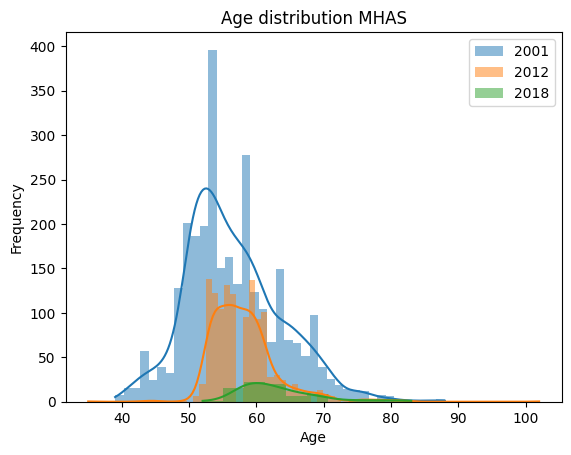

In [17]:
sns.histplot(data=mhas_01, x='r1agey', kde=True, label='2001', alpha=0.5, edgecolor='none')
sns.histplot(data=mhas_12, x='r3agey', kde=True, label='2012', alpha=0.5, edgecolor='none')
sns.histplot(data=mhas_18, x='r5agey', kde=True, label='2018', alpha=0.5, edgecolor='none')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age distribution MHAS')
plt.legend()

plt.show()

In [18]:
cog_age = pd.concat([
    pd.to_numeric(cog_16_p['r1hagey'], errors='coerce').dropna(),
    cog_21[~cog_21['unhhidnp'].isin(cog_16_p['unhhidnp'])]['age_mxcog_21']
])
print(f'MexCog age inclusion: {cog_age.mean():.4f} ± {cog_age.std():.4f}')

MexCog age inclusion: 71.1932 ± 8.5529


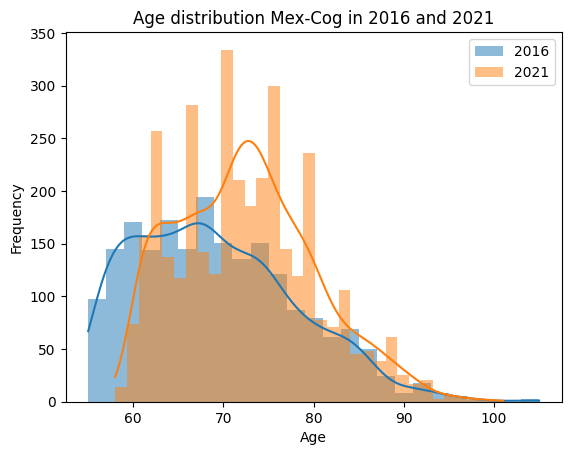

In [19]:
sns.histplot(
    data=pd.to_numeric(cog_16_p['r1hagey'], errors='coerce').dropna(),
    kde=True,
    label='2016', 
    alpha=0.5, 
    edgecolor='none'
)
sns.histplot(
    data=cog_21, 
    x='age_mxcog_21', 
    kde=True, 
    label='2021', 
    alpha=0.5, 
    edgecolor='none'
)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age distribution Mex-Cog in 2016 and 2021')
plt.legend()

plt.show()

## Gender

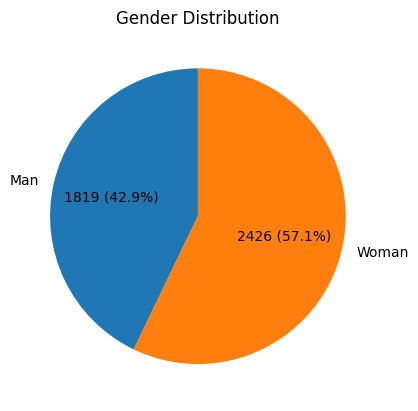

In [20]:
all_gender = mhas_subset['ragender'].value_counts().to_dict()
labels = ['Man', 'Woman']
sizes = [all_gender['1.Man'], all_gender['2.Woman']]
total = sum(sizes)

plt.pie(
    sizes, 
    labels=labels, 
    autopct=lambda x: f'{x*total/100:.0f} ({x:1.1f}%)', 
    startangle=90
)
plt.title('Gender Distribution')
plt.show()

## Education years

In [21]:
ed_years = pd.to_numeric(mhas_subset['raedyrs'], errors='coerce').dropna()
print(f'MHAS education years: {ed_years.mean():.4f} ± {ed_years.std():.4f}')

MHAS education years: 5.2269 ± 4.4520


## Literacy & Numeracy

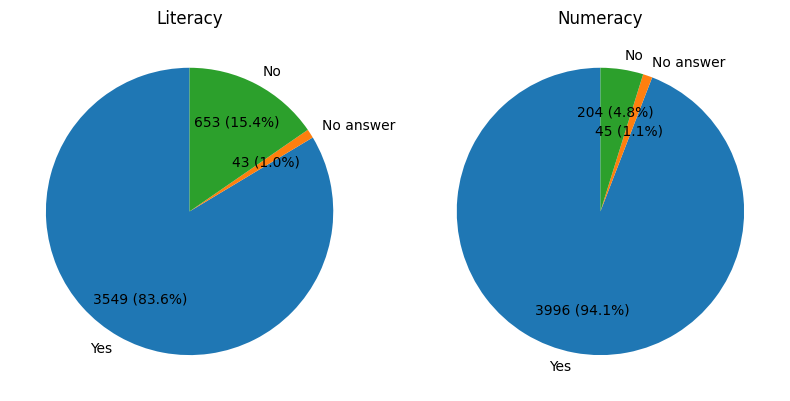

In [22]:
lit = mhas_subset['raliterate'].value_counts().to_dict()
num = mhas_subset['ranumerate'].value_counts().to_dict()
labels = ['Yes','No answer','No']
sizes_lit = [
    lit['1.Yes'],
    mhas_subset.shape[0] - lit['1.Yes'] - lit['0.No'],
    lit['0.No']
]
total_lit = sum(sizes_lit)
sizes_num = [
    num['1.Yes'],
    mhas_subset.shape[0] - num['1.Yes'] - num['0.No'],
    num['0.No']
]
total_num = sum(sizes_num)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

_, pie_labels, text = axs[0].pie(
    sizes_lit, 
    labels=labels, 
    autopct=lambda x: f'{x*total_lit/100:.0f} ({x:1.1f}%)', 
    pctdistance=0.7, 
    startangle=90
)
for autotext, pie_label in zip(text,pie_labels):
    if pie_label.get_text() == 'No answer':
        autotext.set_position((
            0.9 * autotext.get_position()[0],
            0.9 * autotext.get_position()[1]
        ))
axs[0].set_title('Literacy')

_, pie_labels, text = axs[1].pie(
    sizes_num,
    labels=labels, 
    autopct=lambda x: f'{x*total_num/100:.0f} ({x:1.1f}%)',  
    pctdistance=0.7, 
    startangle=90
)
for autotext, pie_label in zip(text,pie_labels):
    if pie_label.get_text() == 'No answer':
        autotext.set_position((
            0.85 * autotext.get_position()[0], 
            0.85 * autotext.get_position()[1]
        ))
axs[1].set_title('Numeracy')

plt.tight_layout()
plt.show()

## Indigenous language

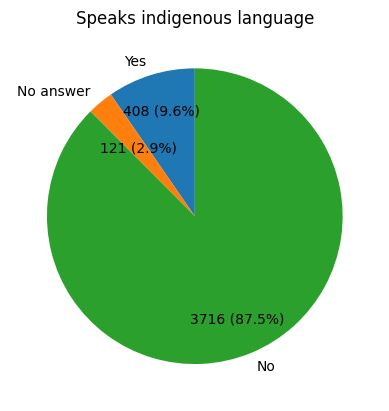

In [23]:
language = mhas_subset['raindlang'].value_counts().to_dict()
labels = ['Yes', 'No answer', 'No']
sizes = [
    language['1.Yes'],
    mhas_subset.shape[0] - language['1.Yes'] - language['0.No'],
    language['0.No']
]
total = sum(sizes)

_, pie_labels, text = plt.pie(
    sizes,
    labels=labels,
    autopct=lambda x: f'{x*total/100:.0f} ({x:1.1f}%)',
    pctdistance=0.75,
    startangle=90
)
for autotext, pie_label in zip(text,pie_labels):
    if pie_label.get_text() == "No answer":
        autotext.set_position((
            0.8 * autotext.get_position()[0],
            0.8 * autotext.get_position()[1]
        ))

plt.title('Speaks indigenous language')
plt.show()

## Household Location
The reported location is based on the last location, meaning the location in the fifth wave

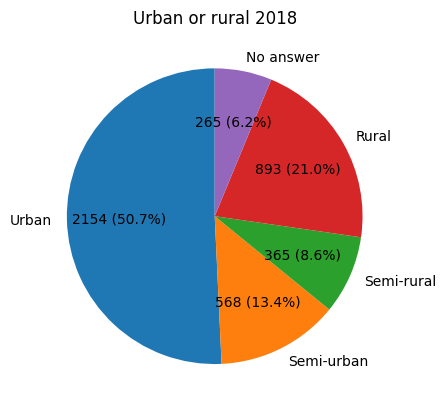

In [24]:
rural = mhas_subset['h5rural_m'].value_counts().to_dict()
labels = ['Urban', 'Semi-urban', 'Semi-rural', 'Rural', 'No answer']
sizes = [
    rural['1.Urban'],
    rural['2.Semi-urban'],
    rural['3.Semi-rural'],
    rural['4.Rural'],
    mhas_subset['h5rural_m'].isna().sum()
]
total = sum(sizes)

plt.pie(
    sizes,
    labels=labels,
    autopct=lambda x: f'{x*total/100:.0f} ({x:1.1f}%)',
    pctdistance=0.65,
    startangle=90
)

plt.title('Urban or rural 2018')
plt.show()


## Couple Household

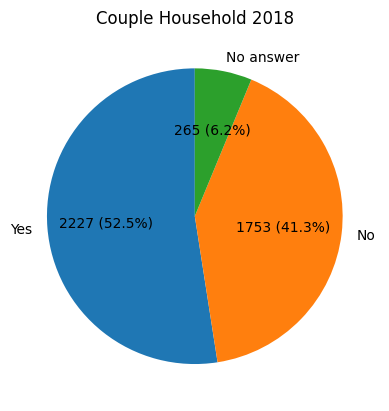

In [25]:
part = mhas_subset['h5cpl'].value_counts().to_dict()
labels = ['Yes', 'No', 'No answer']
sizes = [part['1.Yes'], part['0.No'], mhas_subset['h5cpl'].isna().sum()]
total = sum(sizes)

_, pie_labels, text = plt.pie(
    sizes,
    labels=labels,
    autopct=lambda x: f'{x*total/100:.0f} ({x:1.1f}%)',
    startangle=90
)

plt.title('Couple Household 2018')
plt.show()

## MMSE
This plot doesn't match exactly the one in the second deliverable because we made the decision of keeping the MMSE already provided in the raw MexCog data instead of the one in the harmonized 2016 wave.

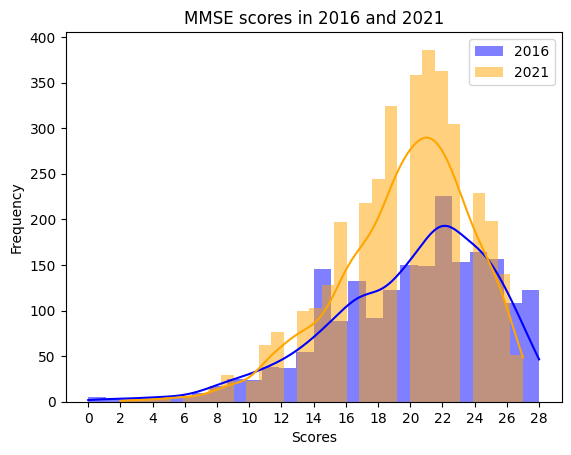

In [26]:
sns.histplot(
    data=cog_16_subset,
    x='MMSE_correct_16',
    kde=True,
    color='blue',
    label='2016',
    alpha=0.5,
    edgecolor='none'
)
sns.histplot(
    data=cog_21_subset,
    x='MMSE_correct_21',
    kde=True,
    color='orange',
    label='2021',
    alpha=0.5,
    edgecolor='none'
)

plt.xticks(range(0,29,2))
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('MMSE scores in 2016 and 2021')
plt.legend()

plt.show()

## CSI'D
Similar to MMSE, this plot doesn't match the one from the deliverable. In this case, we calculated the CSI'D according to the raw variables explained in their corresponding codebooks. Also, we included the 2021 scores.

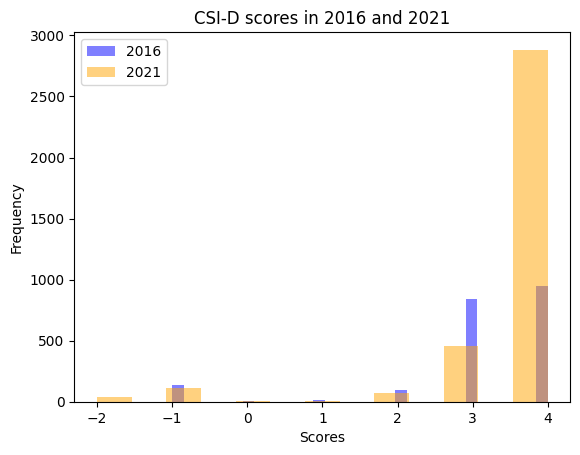

In [27]:
sns.histplot(
    data=cog_16_subset,
    x='CSID_16',
    color='blue',
    label='2016',
    alpha=0.5,
    edgecolor='none'
)
sns.histplot(
    data=cog_21_subset,
    x='CSID_21',
    color='orange',
    label='2021',
    alpha=0.5,
    edgecolor='none'
)

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('CSI-D scores in 2016 and 2021')
plt.legend()

plt.show()